# Notebook with margin trading analysis 
With margin trading the returns often end up being smaller than normal as the drawdowns are much more aggressive.

This is modeled by idetifying stretches of positive returns and buying then. The returns are then calculated as if the position was bought at the start of the stretch.

For strategies, both holdign with postiive sign, and not holdign when predictiosn were low were tried. Positive mo seems to work better, then the neg, and combined though neg could be itterated on.

This returns about the same as both the nasdaq and the SNP500.

May 29th 2023


In [1]:
#Download SNP500 data from 1973 to 2023
#use Yahoo Finance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta


In [2]:
pred_preiod = 7
dist = 0

In [3]:
import yfinance as yf

# Download data for the S&P 500 index from 2020 to 2022
ticker = "SPY" #"SPY"
start_date = "1973-01-01"
end_date = "2023-05-25"
sp500_data = yf.download(ticker, start=start_date, end=end_date)

# Print the first 5 rows of the data
print(sp500_data.head())

[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
1993-01-29  43.96875  43.96875  43.75000  43.93750  25.029364  1003200
1993-02-01  43.96875  44.25000  43.96875  44.25000  25.207407   480500
1993-02-02  44.21875  44.37500  44.12500  44.34375  25.260798   201300
1993-02-03  44.40625  44.84375  44.37500  44.81250  25.527807   529400
1993-02-04  44.96875  45.09375  44.46875  45.00000  25.634624   531500


<Axes: xlabel='Date'>

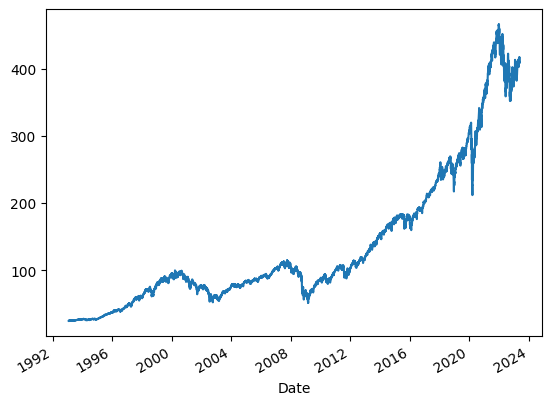

In [4]:
# Plot the adjusted close price
sp500_data["Adj Close"].plot()

In [5]:
#get percent growth from start to end
start_price = sp500_data["Adj Close"][0]
end_price = sp500_data["Adj Close"][-1]
percent_growth = (end_price-start_price)/start_price
print(percent_growth)

15.363524440097404


In [6]:
dataset = pd.DataFrame(sp500_data["Adj Close"])

In [7]:
#get the most important technical indicators
ma_50 = sp500_data["Adj Close"].rolling(window=50).mean()
ma_200 = sp500_data["Adj Close"].rolling(window=200).mean()
ema_50 = sp500_data["Adj Close"].ewm(span=50, adjust=False).mean()
ema_200 = sp500_data["Adj Close"].ewm(span=200, adjust=False).mean()

#get the RSI (relative strength index)
#RSI = 100 - 100/(1 + RS)
rsi = ta.momentum.RSIIndicator(sp500_data["Adj Close"], window=14).rsi()

# Download VIX data from Yahoo Finance
vix = yf.download('^VIX', start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed


In [8]:
rsi

Date
1993-01-29          NaN
1993-02-01          NaN
1993-02-02          NaN
1993-02-03          NaN
1993-02-04          NaN
                ...    
2023-05-18    61.889852
2023-05-19    60.829096
2023-05-22    61.029592
2023-05-23    52.960140
2023-05-24    48.547663
Name: rsi, Length: 7635, dtype: float64

In [9]:
dataset['ma_50'] = ma_50
dataset['ma_200'] = ma_200
dataset['ema_50'] = ema_50
dataset['ema_200'] = ema_200
dataset['rsi'] = rsi

<Axes: xlabel='Date'>

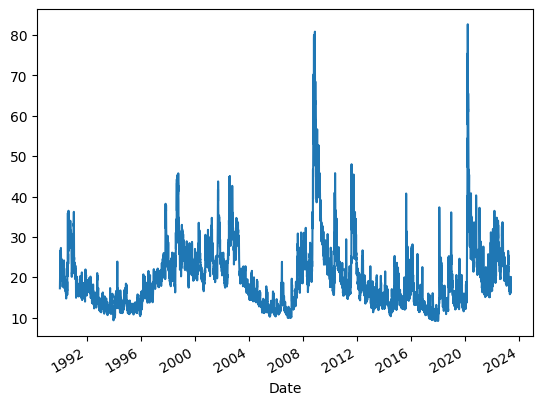

In [10]:
#plot vix
vix["Adj Close"].plot()

In [11]:
#GDP growth, inflation rates, and employment data
import pandas_datareader.data as web


In [12]:
start_date = "1973-01-01"

In [13]:
gdp = web.DataReader('GDPC1', 'fred', start_date, end_date) #Lags behind 6 months
inflation = web.DataReader('CPIAUCSL', 'fred', start_date, end_date) #Lags behind 2 months
unemployment = web.DataReader('UNRATE', 'fred', start_date, end_date) #lags behind 3 months

In [14]:
unemployment

,UNRATE
DATE,
1973-01-01,4.9
1973-02-01,5.0
1973-03-01,4.9
1973-04-01,5.0
1973-05-01,4.9
...,...
2023-01-01,3.4
2023-02-01,3.6
2023-03-01,3.5


In [15]:
#convert inflation to inflatin rate
inflation_rate = inflation.pct_change()
#add smoothed inflation rate
inflation_rate['inflation_rate_12m'] = inflation_rate['CPIAUCSL'].rolling(window=12).mean()

In [16]:
dataset['daily_returns'] = sp500_data["Adj Close"].pct_change().shift(-1)

<Axes: xlabel='DATE'>

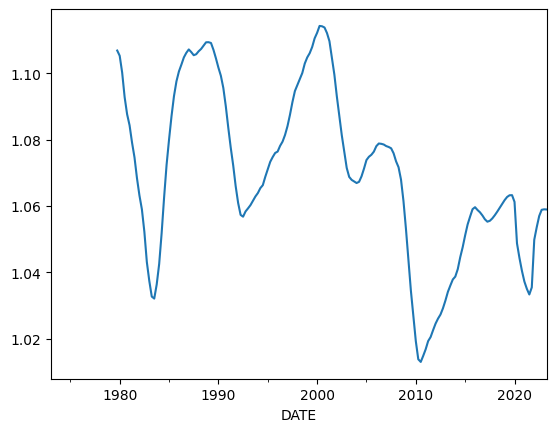

In [17]:
#calculate moving average of GDP
gdp['gdp_7m'] = gdp['GDPC1'].rolling(window=7).mean()
gdp['gdp_28m'] = gdp['GDPC1'].rolling(window=28).mean()
gdp['gdp_ratio'] = (gdp['gdp_7m']/gdp['gdp_28m'])
#plot gdp
gdp['gdp_ratio'].plot()

In [18]:
dataset['gdp_ratio'] = gdp['gdp_ratio']
dataset['unemployment'] = unemployment['UNRATE']
dataset['inflation_rate'] = inflation_rate['inflation_rate_12m']


The Put call ratio should be a good indicator, yet it is recent, and may not be available into the 1970s

<Axes: xlabel='DATE'>

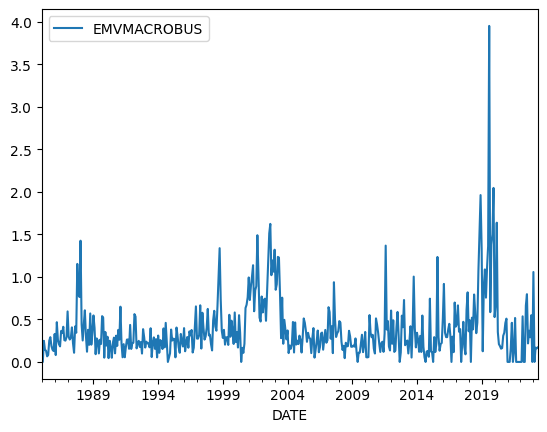

In [19]:
#investor Intelligence Sentiment Index
consumer_sentimet = web.DataReader('UMCSENT', 'fred', start_date, end_date) # Lags behind 
equity_volatility = web.DataReader('EMVMACROBUS', 'fred', start_date, end_date)
#plot iis
equity_volatility.plot()

In [20]:
dataset['consumer_sentimet'] = consumer_sentimet['UMCSENT'] #lags behind 3 mo
dataset['equity_volatility'] = equity_volatility['EMVMACROBUS'] #lags behind 2 mo

In [21]:
dataset.columns

Index(['Adj Close', 'ma_50', 'ma_200', 'ema_50', 'ema_200', 'rsi',
       'daily_returns', 'gdp_ratio', 'unemployment', 'inflation_rate',
       'consumer_sentimet', 'equity_volatility'],
      dtype='object')

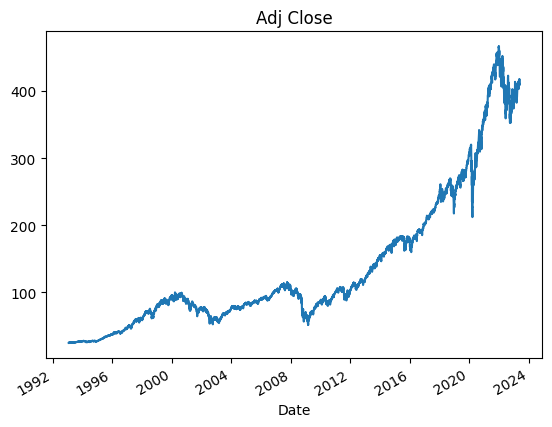

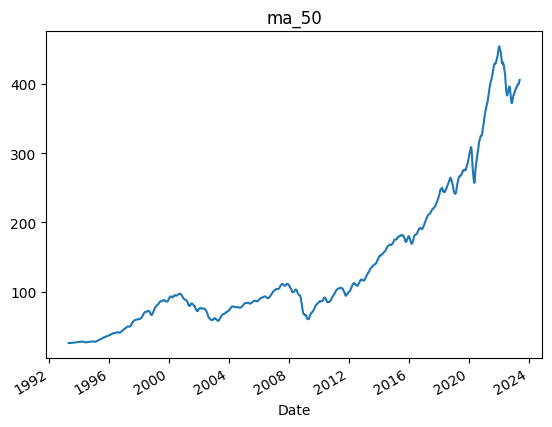

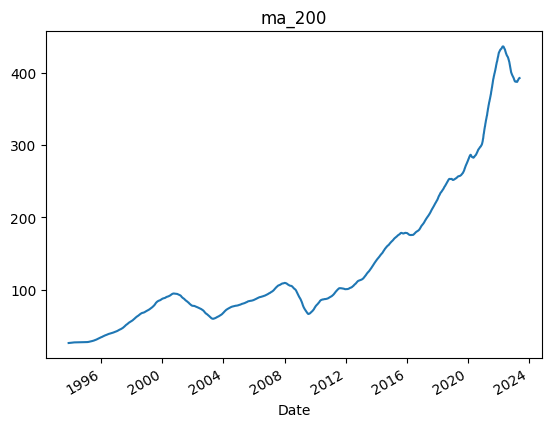

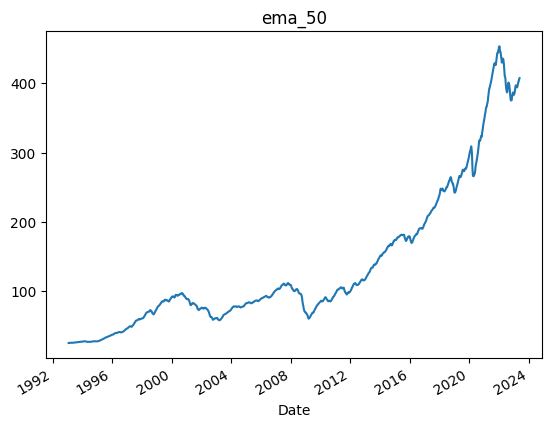

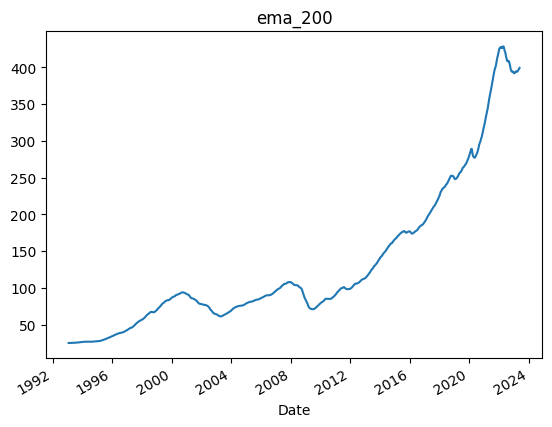

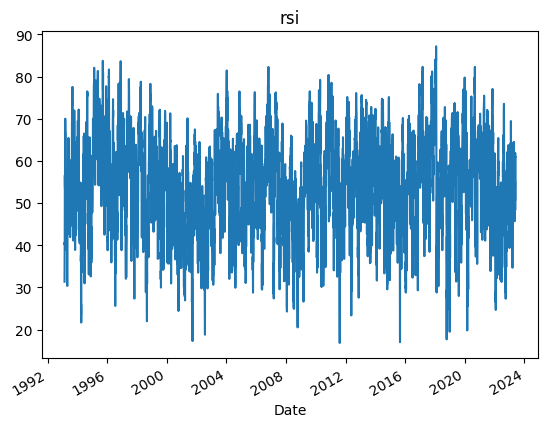

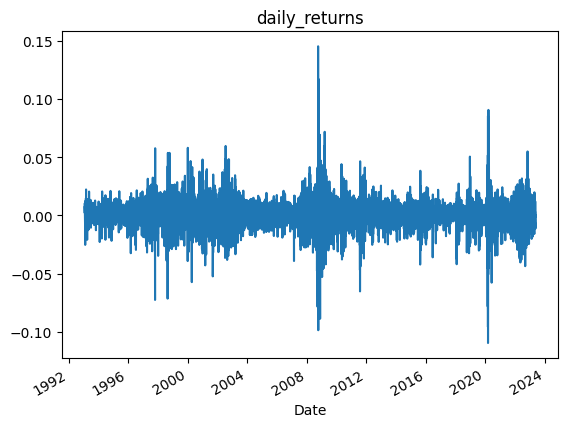

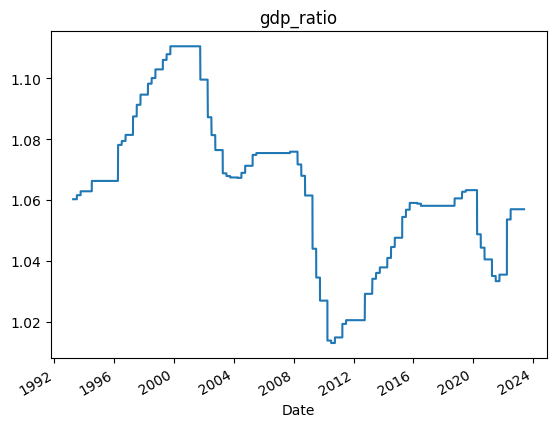

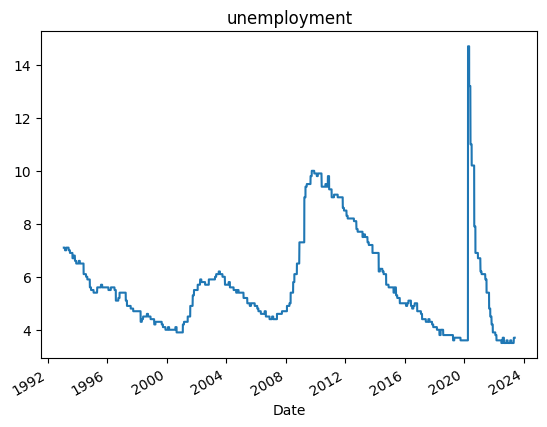

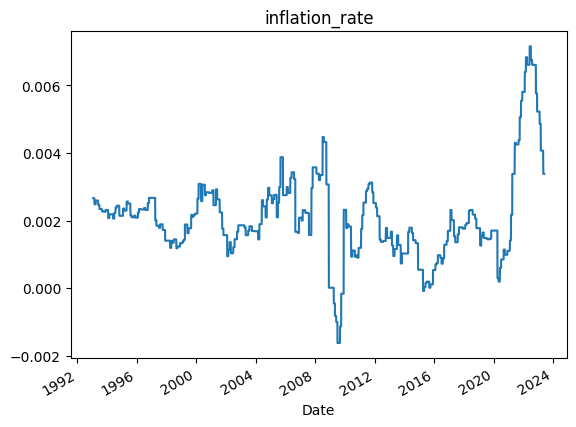

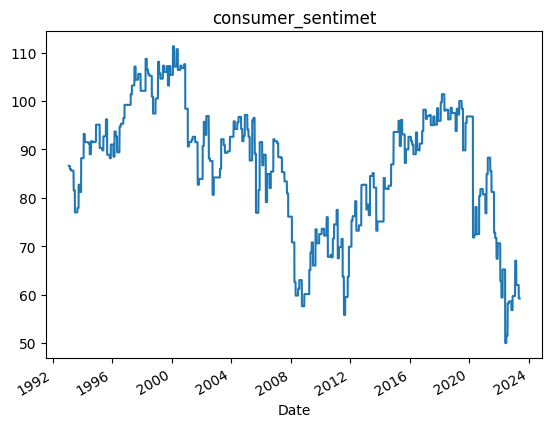

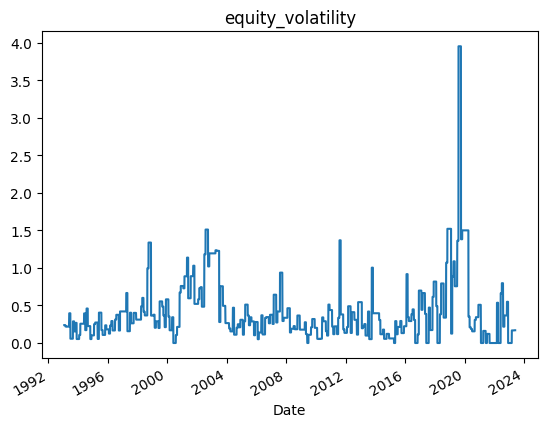

In [22]:
#plot the data for each column
for column in dataset.columns:
    dataset[column].fillna(method='ffill').plot()
    plt.title(column)
    plt.show()

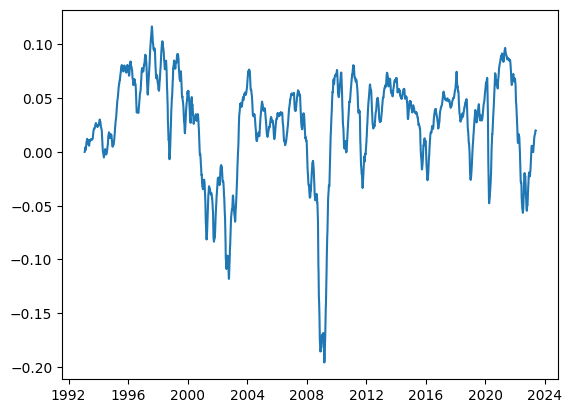

In [23]:
#ema50 - ema200
dataset['norm_ema_ratio'] = (dataset['ema_50'] - dataset['ema_200'])/dataset['ema_200']
plt.plot(dataset['norm_ema_ratio'])

# Create a new column that identifies when the EMAs cross over each other
dataset["EMA_crossover"] = ((dataset['norm_ema_ratio'].shift(1) < 0) & (dataset['norm_ema_ratio'] > 0)).astype(int)


In [24]:
#rsa moving average
dataset['rsi_ma_50'] = dataset['rsi'].rolling(window=50).mean()
dataset['rsi_ma_25'] = dataset['rsi'].rolling(window=25).mean()
dataset['rsi_ma_100'] = dataset['rsi'].rolling(window=100).mean()
dataset['rsi_ma_200'] = dataset['rsi'].rolling(window=200).mean()

In [25]:
dataset['Adj Close'].shift(1)

Date
1993-01-29           NaN
1993-02-01     25.029364
1993-02-02     25.207407
1993-02-03     25.260798
1993-02-04     25.527807
                 ...    
2023-05-18    413.693298
2023-05-19    417.678497
2023-05-22    417.070740
2023-05-23    417.240143
2023-05-24    412.557526
Name: Adj Close, Length: 7635, dtype: float64

In [26]:
# Calculate the rolling mean over a window of thirty days
rolling_mean = dataset['Adj Close'].rolling(window=120).mean()
dataset['percent_increase_smooth'] = (dataset['Adj Close'].shift(-1*pred_preiod) - rolling_mean) / rolling_mean * 100

<Axes: xlabel='Date'>

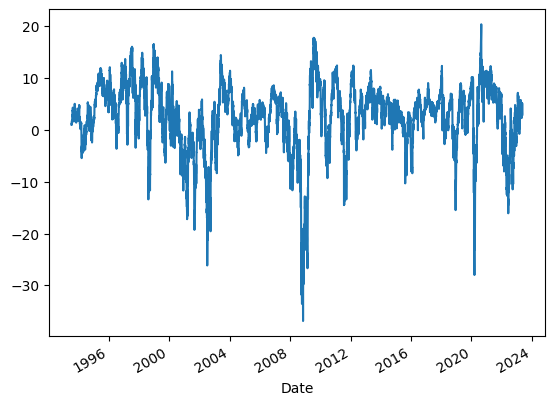

In [27]:
#plot percent increase smooth
dataset['percent_increase_smooth'].plot()

In [28]:
latest_values = dataset.fillna(method='ffill').iloc[-1]

In [29]:
#Adjust data for real time
#gdp  #Lags behind 6 months
#inflation  #Lags behind 2 months
#unemployment  #lags behind 3 months
#dataset['consumer_sentimet'] #lags behind 3 mo
#dataset['equity_volatility'] #lags behind 2 mo

#shift the data


In [30]:
dataset['gdp_ratio'] = dataset['gdp_ratio'].shift(6*20)
dataset['unemployment'] = dataset['unemployment'].shift(3*20)
dataset['inflation_rate'] = dataset['inflation_rate'].shift(2*20)
dataset['consumer_sentimet'] = dataset['consumer_sentimet'].shift(3*20)
dataset['equity_volatility'] = dataset['equity_volatility'].shift(2*20)

In [31]:
print(dataset.columns)
cols_to_model = ['norm_ema_ratio',  'gdp_ratio', 'EMA_crossover', 'rsi', 
       'unemployment', 'consumer_sentimet','inflation_rate',
       'equity_volatility', 'rsi_ma_25','rsi_ma_50','rsi_ma_100',
       'rsi_ma_200']
#percent_inc = (dataset['Adj Close'].shift(-1)/dataset['Adj Close'] - 1)
#find the percent increase over the next 30 days
percent_inc_30 = dataset['percent_increase_smooth']
#percent_inc = (dataset['Adj Close'].shift(-7) / dataset['Adj Close'] - 1) * 100 / 7
y = percent_inc_30.shift(-1)
dataset['pct_growth'] = y
dataset = dataset[:-31]

Index(['Adj Close', 'ma_50', 'ma_200', 'ema_50', 'ema_200', 'rsi',
       'daily_returns', 'gdp_ratio', 'unemployment', 'inflation_rate',
       'consumer_sentimet', 'equity_volatility', 'norm_ema_ratio',
       'EMA_crossover', 'rsi_ma_50', 'rsi_ma_25', 'rsi_ma_100', 'rsi_ma_200',
       'percent_increase_smooth'],
      dtype='object')


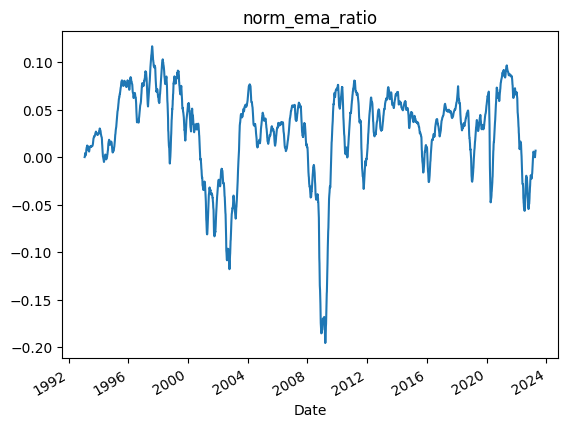

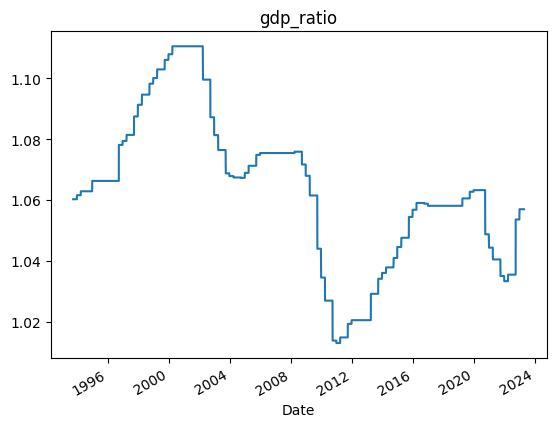

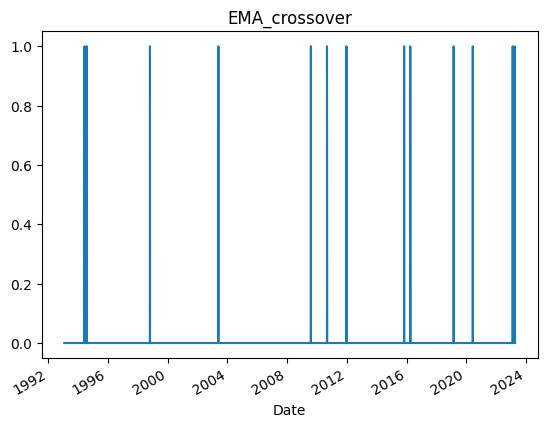

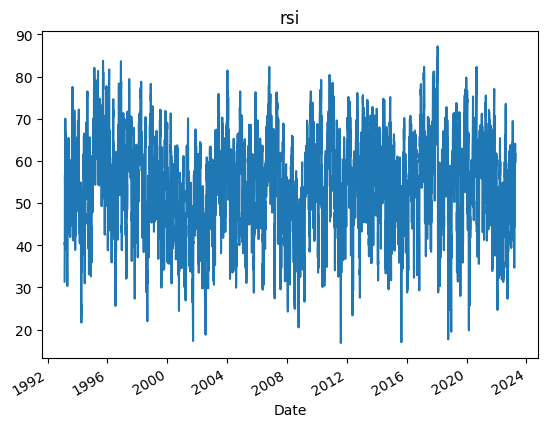

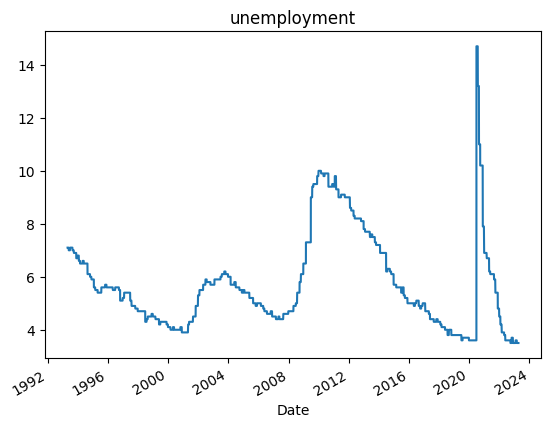

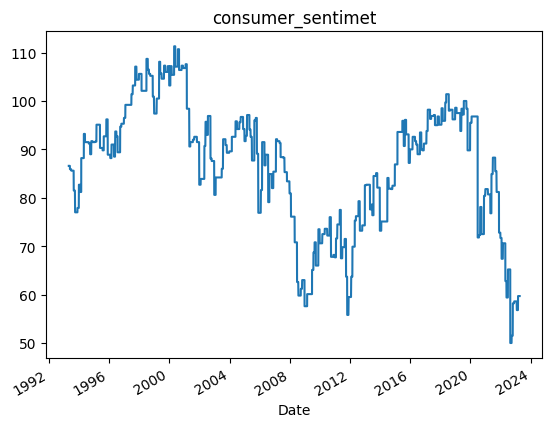

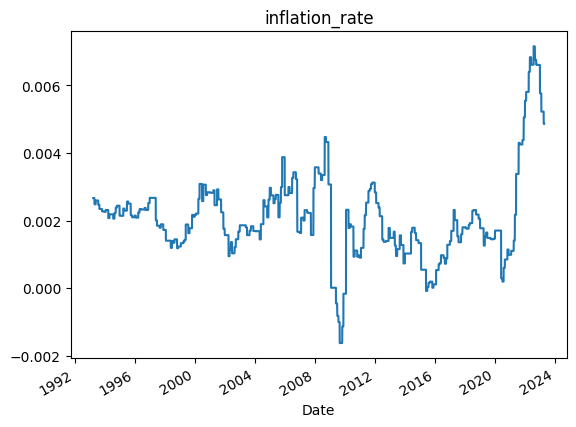

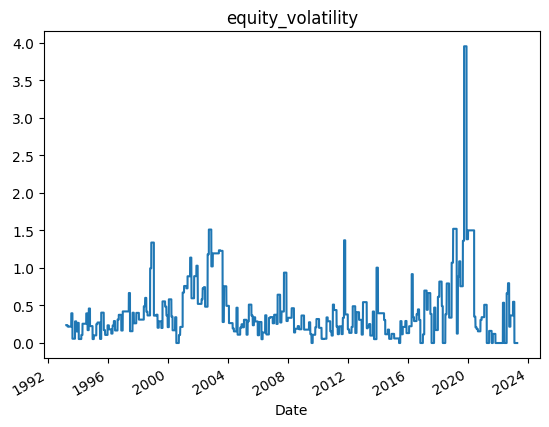

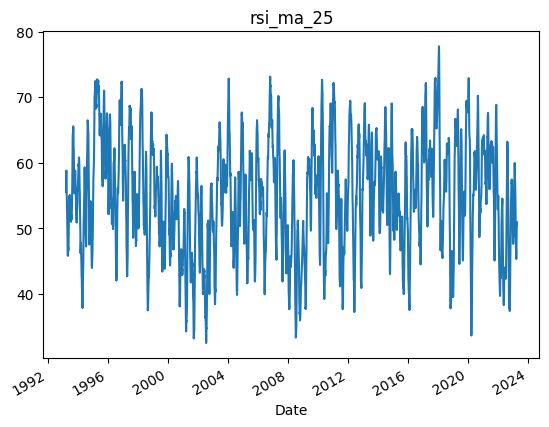

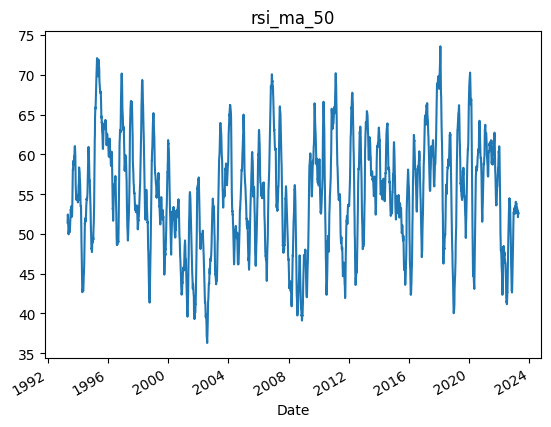

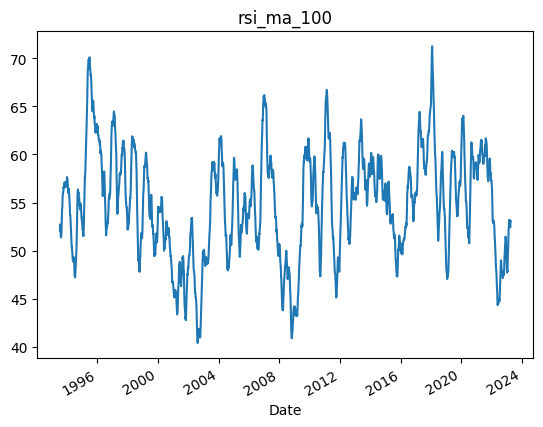

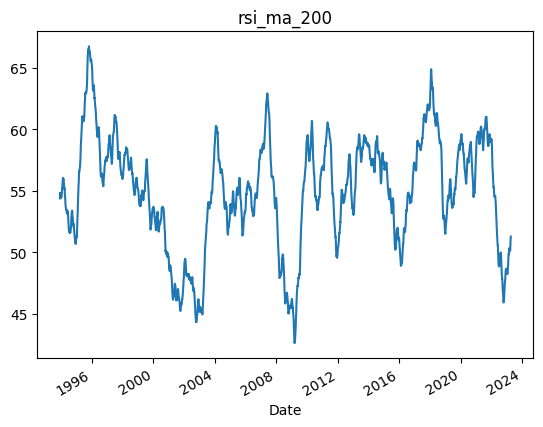

In [32]:

for column in cols_to_model:
    dataset[column].fillna(method='ffill').plot()
    plt.title(column)
    plt.show()

In [33]:
dataset['pct_growth'].median()

3.479696378337941

In [34]:
#get num na values in dataset['pct_growth']
dataset['pct_growth'].isna().sum()
dataset['y'] = .5
dataset.loc[dataset['pct_growth'] > dataset['pct_growth'].median(), 'y'] = 1
dataset.loc[dataset['pct_growth'] < dataset['pct_growth'].median(), 'y'] = 0
dataset['y'] = dataset['pct_growth']

In [35]:
#get number of 1s and 0s
dataset['y'].value_counts()


y
1.016631     1
11.586270    1
5.855430     1
7.504323     1
8.171377     1
            ..
12.335630    1
14.166356    1
14.371498    1
14.471269    1
4.806438     1
Name: count, Length: 7486, dtype: int64

In [36]:
X = dataset[cols_to_model].fillna(method='ffill')
latest_values = latest_values[cols_to_model]
y = dataset['y']
pct_change =  dataset['pct_growth']

In [37]:
#get nan values in X
X.isna().sum()

norm_ema_ratio         0
gdp_ratio            163
EMA_crossover          0
rsi                   13
unemployment          61
consumer_sentimet     61
inflation_rate        41
equity_volatility     41
rsi_ma_25             37
rsi_ma_50             62
rsi_ma_100           112
rsi_ma_200           212
dtype: int64

In [38]:
X = X[212:]
y = y[212:]
dates = dataset.index[212:]
pct_change = pct_change[212:]
pct_returns = dataset['daily_returns'][212:]

In [39]:
len(X)

7392

In [40]:
len(dates)

7392

In [41]:
#get nan values in X
X.isna().sum()

norm_ema_ratio       0
gdp_ratio            0
EMA_crossover        0
rsi                  0
unemployment         0
consumer_sentimet    0
inflation_rate       0
equity_volatility    0
rsi_ma_25            0
rsi_ma_50            0
rsi_ma_100           0
rsi_ma_200           0
dtype: int64

In [42]:
#drop values where y is 0
# X = X[y != .5]
# pct_change = pct_change[y != .5]
# dates = dates[y != .5]
# y = y[y != .5]


In [43]:
#split y to be values greater and less than the mean
mean_y = y.median()
y[y <= mean_y] = 0
y[y > mean_y] = 1

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()

seed = 42

kf = KFold(n_splits=5, shuffle=False)

#split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=False)
# # Fit the scaler to your data to calculate the mean and standard deviation

scaler.fit(X_train)

#get nan values in dataset
print(X_train.isna().sum())

# # Apply the scaler to your data to transform it to a normalized form
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_scaled = scaler.transform(X)
latest_values_scaled = scaler.transform(latest_values[cols_to_model].values.reshape(1, -1))


norm_ema_ratio       0
gdp_ratio            0
EMA_crossover        0
rsi                  0
unemployment         0
consumer_sentimet    0
inflation_rate       0
equity_volatility    0
rsi_ma_25            0
rsi_ma_50            0
rsi_ma_100           0
rsi_ma_200           0
dtype: int64


/Users/andrew/opt/anaconda3/envs/trading_modeling/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [45]:
# #seperate the data into 
# #split the training into 5 fold cross validation
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import KFold
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression

# scaler = StandardScaler()

# seed = 42

# kf = KFold(n_splits=5, shuffle=False)

# #split the data into training and testing
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=False)
# # # Fit the scaler to your data to calculate the mean and standard deviation

# scaler.fit(X_train)

# #get nan values in dataset
# print(X_train.isna().sum())

# # # Apply the scaler to your data to transform it to a normalized form
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# #count number of nan values in X_train_scaled
# print(np.isinf(X_train_scaled).sum())

# #split train into 5 fold cross validation
# kf = KFold(n_splits=5, shuffle=False)

# scores = []
# correlations = []
# preds = []
# gt = []
# for train_idx, val_idx in kf.split(X_train_scaled):
#     # split the data into training and validation sets for this fold
#     train_X, val_X = X_train_scaled[train_idx], X_train_scaled[val_idx]
#     train_y, val_y = y_train[train_idx], y_train[val_idx]

#     pct_change_train, pct_change_val = pct_change[train_idx], pct_change[val_idx]
#     #trainX and Y where percent_change < 0 or > 10

#     train_X = train_X[(pct_change_train < median-dist) | (pct_change_train > median+dist)]
#     train_y = train_y[(pct_change_train < median-dist) | (pct_change_train > median+dist)]

#     #count number of nan values in X_train_scaled
#     print(np.isnan(train_y).sum())

#     # fit the model for this fold
#     model = LinearRegression()
#     model.fit(train_X, train_y)

#     #predict for this fold
#     pred = model.predict(val_X)
#     preds.append(pred)
#     gt.append(val_y)

#     #calculate rmse for this fold
#     rmse = np.sqrt(np.mean((model.predict(val_X) - val_y) ** 2))
#     scores.append(rmse)

#     #calculate correlation for this fold
#     corr = np.corrcoef(model.predict(val_X), val_y)[0, 1]
#     correlations.append(corr)

# print(scores)
# print(correlations)

In [46]:
# for train_idx, val_idx in kf.split(X_train_scaled):
#     min_val_idx = min(val_idx)
#     max_val_idx = max(val_idx)
#     train_idx = [i for i in train_idx if i < min_val_idx-30 and i > max_val_idx]

In [47]:
len(y)

7392

In [48]:
#create use XGBoost model for regression
import xgboost as xgb
from sklearn.metrics import mean_squared_error

scaler = StandardScaler()

seed = 42

kf = KFold(n_splits=5, shuffle=False)

#split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=False)

# # Fit the scaler to your data to calculate the mean and standard deviation
scaler.fit(X_train)

#get nan values in dataset
print(X_train.isna().sum())

# # Apply the scaler to your data to transform it to a normalized form
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



norm_ema_ratio       0
gdp_ratio            0
EMA_crossover        0
rsi                  0
unemployment         0
consumer_sentimet    0
inflation_rate       0
equity_volatility    0
rsi_ma_25            0
rsi_ma_50            0
rsi_ma_100           0
rsi_ma_200           0
dtype: int64


<Axes: >

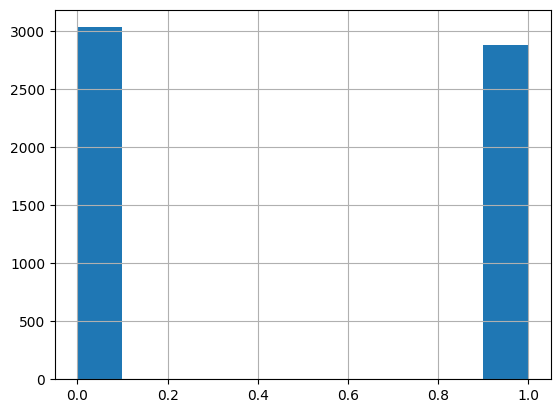

In [49]:
y_train.hist()

In [50]:
#remove values that don't matter much
mean_dist = np.mean(y_train)
print(mean_dist)

0.48672416708946387


In [51]:
len(y_train)

5913

In [52]:
X_train_scaled.shape

(5913, 12)

In [53]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

param_dist = {
    'max_depth': randint(1, 10),
    'learning_rate': uniform(0.01, 0.5),
    'n_estimators': randint(50, 500),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 2)
}

#y_train = np.where(y_train < 0, y_train, y_train)
xgb_class = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_cv = RandomizedSearchCV(xgb_class, param_dist, cv=kf, n_iter=100, random_state=42, n_jobs=-1)


trn_idxs = (y_train < mean_dist-dist) | (y_train > mean_dist+dist)
X_train_scaled_extreme, train_y_extreme = X_train_scaled[trn_idxs], y_train[trn_idxs]
xgb_cv.fit(X_train_scaled_extreme, train_y_extreme)

print(xgb_cv.best_params_)

# xgb_model = xgb.XGBRegressor(**xgb_cv.best_params_)
# xgb_model.fit(X_train_scaled, y_train)

# # Evaluate on test set
# test_pred = xgb_model.predict(X_test_scaled)
# test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
# test_corr = np.corrcoef(test_pred, y_test)[0, 1]

# print('Test RMSE:', test_rmse)
# print('Test correlation:', test_corr)

{'colsample_bytree': 0.7816441089227697, 'gamma': 0.7708330050798322, 'learning_rate': 0.0179831261101071, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 141, 'subsample': 0.7200762468698007}


In [54]:
configs = xgb_cv.best_params_

train_scores = []
scores = []
correlations = []
preds = []
gt = []
for train_idx, val_idx in kf.split(X_train_scaled):

    min_val_idx = min(val_idx)
    max_val_idx = max(val_idx)
    train_idx = [i for i in train_idx if i < min_val_idx-pred_preiod or i > max_val_idx]

    # split the data into training and validation sets for this fold
    train_X, val_X = X_train_scaled[train_idx], X_train_scaled[val_idx]
    train_y, val_y = y_train[train_idx], y_train[val_idx]
    #add more weight to values < 0

    #trainX and Y where percent_change < 0 or > 10
    trn_idxs = (train_y < mean_dist-dist) | (train_y > mean_dist+dist)
    train_X, train_y = train_X[trn_idxs], train_y[trn_idxs]
    
    #load xgb model from config
    xgb_model = xgb.XGBClassifier(objective='reg:squarederror', **configs)

    xgb_model.fit(train_X, train_y)

    #predict for this fold
    pred = xgb_model.predict_proba(val_X)[:,-1]
    preds.append(pred)
    gt.append(val_y)

    train_rmse = np.sqrt(mean_squared_error(train_y, xgb_model.predict(train_X)))
    train_scores.append(train_rmse)

    #calculate rmse for this fold
    rmse = np.sqrt(np.mean((xgb_model.predict(val_X) - val_y) ** 2))
    scores.append(rmse)

    #calculate correlation for this fold
    corr = np.corrcoef(xgb_model.predict(val_X), val_y)[0, 1]
    correlations.append(corr)

print(train_scores)
print(scores)
print(correlations)

[0.3808302935344994, 0.3755157368213292, 0.34861572538970476, 0.38958715854952053, 0.3543010196594878]
[0.4080757061016954, 0.40286379735875516, 0.44664618533849615, 0.3803551639736489, 0.484968643778536]
[0.6200662409638609, 0.5670704494664077, 0.60117137131142, 0.7060977734142968, 0.5183352788989652]


In [55]:
exp_preds = np.concatenate(preds)
pct_returns_train = pct_returns[:int(len(pct_change)*.8)]

In [56]:
#here's the backtesting strategy
#If the model predicts a positive return, long the SNP500, if it falls below zero then short the SNP500
#Even though the predictions are a month away, this is a good way to backtest the model

In [57]:
# from sklearn.metrics import roc_auc_score
# #calculate the correlation between the predictions and the actual values
# corr = np.corrcoef(exp_preds, gt)[0, 1]
# print(corr)
#roc_score = roc_auc_score(gt, exp_preds)
# roc_score = roc_auc_score(y_train, exp_preds)
# print(roc_score)

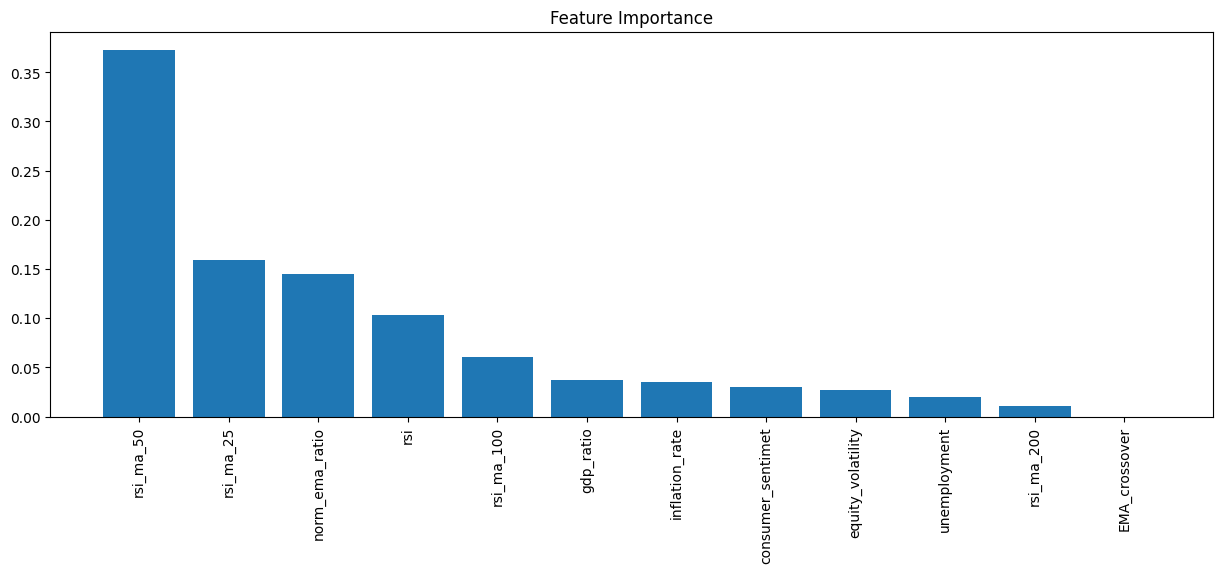

In [58]:
#find the most important features in the model
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

#plot the most important features
plt.figure(figsize=(15, 5))
plt.title("Feature Importance")
plt.bar(range(X_train_scaled.shape[1]), importances[indices])
plt.xticks(range(X_train_scaled.shape[1]), names, rotation=90)
plt.show()

In [59]:
len(dates[:int(.8*len(dates))])

5913

In [60]:
len(y_train)

5913

Text(0.5, -0.11, 'Predictions from basic xgboost logistic regression. Y is increase in price in 1.5 weeks over current avg. \nThe overall validation has a correlation of ~.5, yet when using it for trading the performance is unsucceseful')

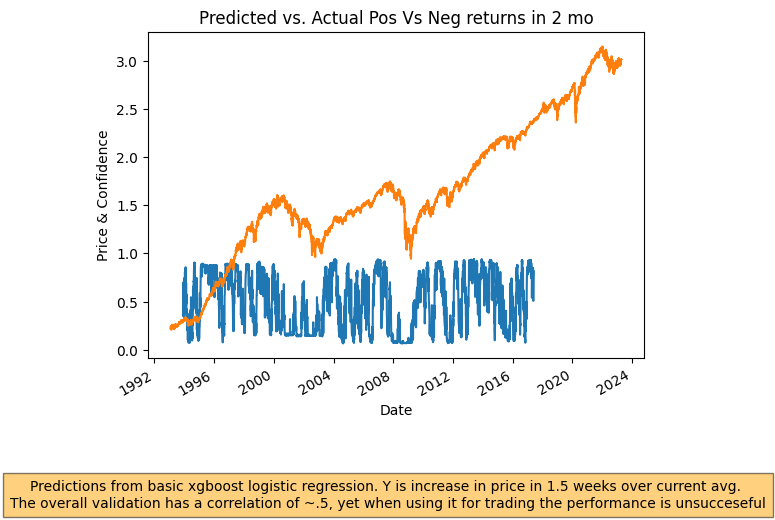

In [61]:
#plot exp_preds as a function of time
plt.plot(dates[:int(.8*len(dates))],exp_preds)
#plot dataset with adjusted close
#dataset['Adj Close'].plot()
#plot the log of the adjusted close
(np.log(dataset['Adj Close'])-3).plot()
plt.title('Predicted vs. Actual Pos Vs Neg returns in 2 mo')
plt.xlabel('Date')
plt.ylabel('Price & Confidence')
#add caption below plot
text = "Predictions from basic xgboost logistic regression. Y is increase in price in 1.5 weeks over current avg. \n"+\
        "The overall validation has a correlation of ~.5, yet when using it for trading the performance is unsucceseful"
plt.figtext(0.5, -0.11, text, ha='center', fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

#save plot to cache_notebooks/snp500_xgboost_classification.ipynb
#plt.savefig('../graph_results/snp500_xgboost_classification.png', bbox_inches='tight')

In [62]:
np.mean(exp_preds)
#get the 90th percentile of the predictions
np.percentile(exp_preds, 70)

0.7433961033821105

Finding the best threshold and days to hold for a strategy \
Logic is simple: Given an indicator. If it goes above a threshold, we buy and hold for a certain numebr of days \
We do random search to find the best threshold and days to hold

In [63]:
percentile_lst = []
days_to_hold_lst = []
returns = []
returns_calc_2 = []
run_strategy_hp_search = False


if(run_strategy_hp_search):
    for percentile_threshold in [70,75,80,85,90]:
        for days_to_hold in [7, 15, 30, 60, 120]:
            threshold = np.percentile(exp_preds, percentile_threshold)

            dates_in_pos_mo = []
            for i in dates[:int(.8*len(dates))][exp_preds > threshold]:
                for j in pd.date_range(i, periods=days_to_hold, freq='D'):
                    if (j not in dates_in_pos_mo):
                        dates_in_pos_mo.append(j)
            dates_in_pos_mo = [i for i in dates_in_pos_mo if i in dates[:int(.8*len(dates))]]
            #make dates_in_pos_mo unique
            dates_in_pos_mo = sorted(list(set(dates_in_pos_mo)))
            train_dates = dates[:int(.8*len(dates))]

            model_returns = (1+pct_returns_train[train_dates.isin(dates_in_pos_mo)]).cumprod()
            pct_return = model_returns[-1] / np.array(([1.0002484] * len(model_returns))).cumprod()[-1]
            returns_calc_2 = (1+4*(pct_returns_train[train_dates.isin(dates_in_pos_mo)]-.0002484)).cumprod()[-1]


            percentile_lst.append(percentile_threshold)
            days_to_hold_lst.append(days_to_hold)
            returns.append(pct_return)

            print('Percent Return: ', pct_return, 'Returns_calc_2 ', returns_calc_2,  'Percentile Threshold: ', percentile_threshold, 'Days to Hold: ', days_to_hold)
#Percent Return:  2.3512213129425183 Percentile Threshold:  55 Days to Hold:  120


In [64]:
threshold = np.percentile(exp_preds, 70)

In [65]:
dates_in_pos_mo = []
for i in dates[:int(.8*len(dates))][exp_preds > threshold]:
    for j in pd.date_range(i, periods=120, freq='D'):
        if (j not in dates_in_pos_mo):
            dates_in_pos_mo.append(j)
dates_in_pos_mo = [i for i in dates_in_pos_mo if i in dates[:int(.8*len(dates))]]
#make dates_in_pos_mo unique
dates_in_pos_mo = sorted(list(set(dates_in_pos_mo)))

In [66]:
train_dates = dates[:int(.8*len(dates))]

In [67]:
lower_threshold = np.percentile(exp_preds, 20)

In [68]:
dates_in_neg_mo = []
streaks = []


for i in dates[:int(.8*len(dates))][exp_preds < lower_threshold]:
    for j in pd.date_range(i, periods=7, freq='D'):
        if (j not in dates_in_neg_mo):
            dates_in_neg_mo.append(j)
dates_in_neg_mo = [i for i in dates_in_neg_mo if i in dates[:int(.8*len(dates))]]
#make dates_in_pos_mo unique
dates_in_neg_mo = sorted(list(set(dates_in_neg_mo)))
dates_in_neg_mo

[Timestamp('1994-03-24 00:00:00'),
 Timestamp('1994-03-25 00:00:00'),
 Timestamp('1994-03-28 00:00:00'),
 Timestamp('1994-03-29 00:00:00'),
 Timestamp('1994-03-30 00:00:00'),
 Timestamp('1994-03-31 00:00:00'),
 Timestamp('1994-04-04 00:00:00'),
 Timestamp('1994-04-05 00:00:00'),
 Timestamp('1994-04-06 00:00:00'),
 Timestamp('1994-04-07 00:00:00'),
 Timestamp('1994-04-08 00:00:00'),
 Timestamp('1994-04-11 00:00:00'),
 Timestamp('1994-04-12 00:00:00'),
 Timestamp('1994-04-13 00:00:00'),
 Timestamp('1994-04-14 00:00:00'),
 Timestamp('1994-04-15 00:00:00'),
 Timestamp('1994-04-18 00:00:00'),
 Timestamp('1994-04-19 00:00:00'),
 Timestamp('1994-04-20 00:00:00'),
 Timestamp('1994-04-21 00:00:00'),
 Timestamp('1994-04-22 00:00:00'),
 Timestamp('1994-04-25 00:00:00'),
 Timestamp('1994-04-26 00:00:00'),
 Timestamp('1994-04-28 00:00:00'),
 Timestamp('1994-04-29 00:00:00'),
 Timestamp('1994-05-02 00:00:00'),
 Timestamp('1994-05-03 00:00:00'),
 Timestamp('1994-05-04 00:00:00'),
 Timestamp('1994-05-

3.750203628835397

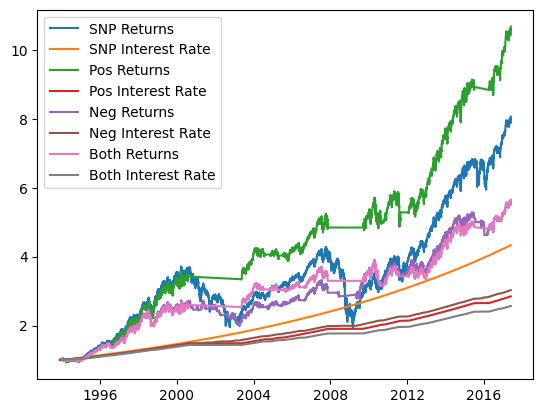

In [70]:
snp_returns = (1+pct_returns_train).cumprod()
pos_model_returns = (1+pct_returns_train[train_dates.isin(dates_in_pos_mo)]).cumprod()
neg_model_returns = (1+pct_returns_train[~train_dates.isin(dates_in_neg_mo)]).cumprod()
neg_mo_train_dates = train_dates[~train_dates.isin(dates_in_neg_mo)]
both_model_returns = (1+pct_returns_train[~train_dates.isin(dates_in_neg_mo) & train_dates.isin(dates_in_pos_mo)]).cumprod()
both_mo_train_dates = train_dates[~train_dates.isin(dates_in_neg_mo) & train_dates.isin(dates_in_pos_mo)]
# print(len(model_returns))
# print(len(neg_mo_train_dates))

#plot the strategy returns and pct_returns
plt.plot(train_dates, snp_returns, label='SNP Returns')
plt.plot(train_dates, np.array(([1.000248] * len(dates[:int(.8*len(dates))]))).cumprod(), label='SNP Interest Rate')
plt.plot(dates_in_pos_mo, pos_model_returns, label='Pos Returns')
plt.plot(dates_in_pos_mo, np.array(([1.000248] * len(pos_model_returns))).cumprod(), label='Pos Interest Rate')
plt.plot(neg_mo_train_dates, neg_model_returns, label='Neg Returns')
plt.plot(neg_mo_train_dates, np.array(([1.000248] * len(neg_model_returns))).cumprod(), label='Neg Interest Rate')
plt.plot(both_mo_train_dates, both_model_returns, label='Both Returns')
plt.plot(both_mo_train_dates, np.array(([1.000248] * len(both_model_returns))).cumprod(), label='Both Interest Rate')
plt.legend()

model_returns = (1+pct_returns_train[train_dates.isin(dates_in_pos_mo)]).cumprod()

model_returns[-1]/np.array(([1.000248] * len(model_returns))).cumprod()[-1]

In [71]:
"""
Max drawdown is calculated by a saying that we borrow at 33% * stock value and have a minimum of 25% of the stock value in cash
This means that we can have a max loss of 91%. 

#cash value = .25 * stock value
(1-3x) = .25(3-x)
1=11x
"""
max_drawdown = .91

In [72]:
def convt_pos_dates_to_streaks(dates_in_pos_mo, train_dates):
    """Given a set of train dates (train_dates), splits them into a list of lists. 
    Each list is a streak of consecutive dates when we hold.

    Args:
        dates_in_pos_mo (List): a list of dates when we hold
        train_dates (List): a list of all the dates in the training set
            These are consecutive, by which I mean that train_dates[i+1] - train_dates[i] = 1 day
    """
    in_streak = False
    streaks = []
    for i in range(len(train_dates)):
        if(not in_streak and train_dates[i] in dates_in_pos_mo):
            in_streak = True
            streaks.append([train_dates[i]])
        elif(in_streak and train_dates[i] in dates_in_pos_mo):
            streaks[-1].append(train_dates[i])
        elif(train_dates[i] not in dates_in_pos_mo):
            in_streak = False
        else:
            print('error')
    return streaks
        
streaks = convt_pos_dates_to_streaks(dates_in_pos_mo, train_dates)

In [73]:
#import logger
import logging

#set up logger with info level
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Create a console handler and set its log level to INFO
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.INFO)
console_handler.setFormatter(formatter)

logger.handlers.clear()
logger.addHandler(console_handler)

2023-08-13 18:25:08,039 - __main__ - INFO - Returns wo floor: [0.865541380941771, 3.653881401746541, 1.2490569808414365, 1.510982321506392, 1.030373427682912, 1.2938454439197902, 0.8936766023208486, 1.0418878429500487, 0.9647460581769522, 1.1176317970015808, 0.891210981495876, 1.021512113154563, 2.0894510277405423, 1.3406288353917675]


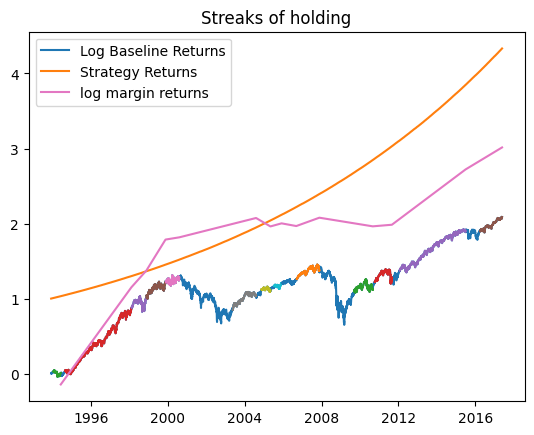

In [74]:
def plot_streaks(dates_in_pos_mo, train_dates, pct_returns_train):
    """Plots the streaks of dates when we hold

    Args:
        streaks (List): a list of lists of dates when we hold
        train_dates (List): a list of all the dates in the training set
            These are consecutive, by which I mean that train_dates[i+1] - train_dates[i] = 1 day
        pct_returns_train (List): a list of the percent returns for each date in train_dates
    """
    margin_rate = 3
    interest_rate = .0002484
    max_drawdown = .91
    #calculate the returns for each streak
    streaks = convt_pos_dates_to_streaks(dates_in_pos_mo, train_dates)
    streak_rets = []
    min_rets = []
    for streak in streaks:
        ret = (1+pct_returns_train[train_dates.isin(streak)] - interest_rate).cumprod()[-1]
        min_ret = (1+pct_returns_train[train_dates.isin(streak)]).cumprod().min()
        min_rets.append(min_ret)
        margin_ret = 1 + margin_rate * (ret - 1)
        streak_rets.append(margin_ret)

    logger.info(msg = f"Returns wo floor: {streak_rets}")

    streak_rets = [streak_rets[i] if min_rets[i] > max_drawdown else .70 for i in range(len(streak_rets))]
    snp_returns = (1+pct_returns_train).cumprod()


    plt.plot(train_dates, np.log(snp_returns), label='Log Baseline Returns')
    plt.plot(train_dates, np.array(([1.000248] * len(dates[:int(.8*len(dates))]))).cumprod(), label='Strategy Returns')

    #plot the dates in the streaks in a different collor
    for streak in streaks:
        plt.plot(streak, np.log(snp_returns)[train_dates.isin(streak)])


    #plot the streaks
    streak_ends = [streak[-1] for streak in streaks]
    plt.plot(streak_ends, np.log(np.cumprod(streak_rets)), label = 'log margin returns')
    plt.title('Streaks of holding')
    plt.legend()


plot_streaks(dates_in_pos_mo, train_dates, pct_returns_train)

Looking at the test data

In [75]:
test_dates = dates[int(.8*len(dates)):]
test_pred = xgb_model.predict_proba(X_test_scaled)[:,-1]

0.7122371628180645


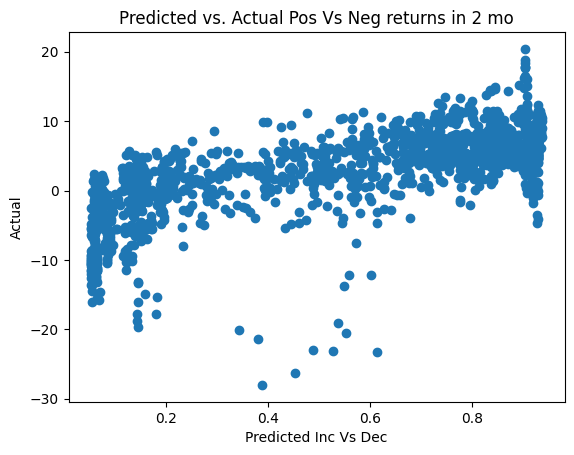

In [76]:

gt = pct_change[:int(len(pct_change)*.8)]
gt_test = pct_change[int(len(pct_change)*.8):]
pct_returns_test = pct_returns[int(len(pct_change)*.8):]

plt.scatter(test_pred, gt_test)
plt.title('Predicted vs. Actual Pos Vs Neg returns in 2 mo')
plt.xlabel('Predicted Inc Vs Dec')
plt.ylabel('Actual')

#plot the correlation between predicted and actual
print(np.corrcoef(test_pred, gt_test)[0, 1])
#plot a histogram of the scores
# for i in zip(preds, gt):
#     # scatter plot
#     plt.scatter(i[0], i[1])


Text(0.5, -0.11, 'Predictions from basic xgboost regression. Y is increase in price in 2 months over current avg. \nFor training, it is filtered to remove avg points. The overall AUC score is .55. \n Please see the code in cache_notebooks/snp500_xgboost_classification.ipynb')

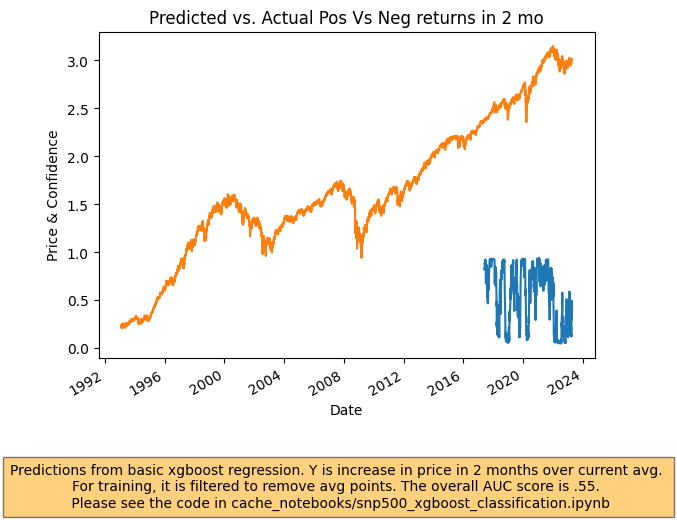

In [77]:
#plot exp_preds as a function of time
plt.plot(test_dates,test_pred)
#plot dataset with adjusted close
#dataset['Adj Close'].plot()
#plot the log of the adjusted close
(np.log(dataset['Adj Close'])-3).plot()
plt.title('Predicted vs. Actual Pos Vs Neg returns in 2 mo')
plt.xlabel('Date')
plt.ylabel('Price & Confidence')
#add caption below plot
text = "Predictions from basic xgboost regression. Y is increase in price in 2 months over current avg. \n"+\
        "For training, it is filtered to remove avg points. The overall AUC score is .55. \n Please see the code in cache_notebooks/snp500_xgboost_classification.ipynb"
plt.figtext(0.5, -0.11, text, ha='center', fontsize=10, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

#save plot to cache_notebooks/snp500_xgboost_classification.ipynb
#plt.savefig('../graph_results/snp500_xgboost_classification.png', bbox_inches='tight')

In [78]:
dates_in_pos_mo = []
for i in test_dates[test_pred > threshold]:
    for j in pd.date_range(i, periods=120, freq='D'):
        if (j not in dates_in_pos_mo):
            dates_in_pos_mo.append(j)
dates_in_pos_mo = [i for i in dates_in_pos_mo if i in test_dates]

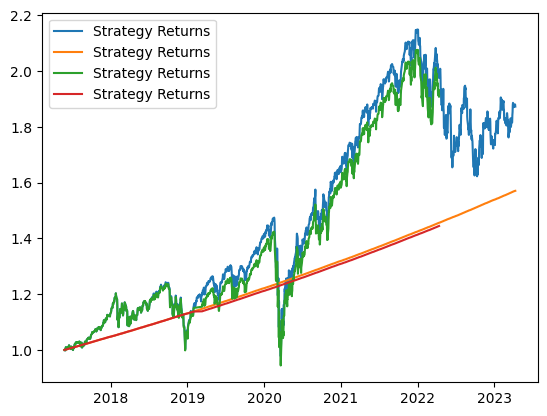

In [79]:
#plot the strategy returns and pct_returns
plt.plot(test_dates, (1+pct_returns_test).cumprod(), label='Strategy Returns')
plt.plot(test_dates, np.array(([1.0003054] * len(test_dates))).cumprod(), label='Strategy Returns')
plt.plot(dates_in_pos_mo, (1+pct_returns_test[test_dates.isin(dates_in_pos_mo)]).cumprod(), label='Strategy Returns')
plt.plot(dates_in_pos_mo, np.array(([1.0003054] * len(dates_in_pos_mo))).cumprod(), label='Strategy Returns')

#plt.plot(dates[:int(.8*len(dates))], (1+np.array(pct_returns)).cumprod(), label='S&P500 Returns')
plt.legend()

In [80]:
xgb_model = xgb.XGBClassifier(objective='reg:squarederror', **configs)
xgb_model.fit(X_scaled, y)

print('threshold is ', threshold)
xgb_model.predict_proba(latest_values_scaled)[:,-1]

threshold is  0.7433961033821105


array([0.43040588], dtype=float32)